In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc3 as pm
import theano

In [2]:
elements = pd.read_csv('pd_data/elements_men.csv')
components = pd.read_csv('pd_data/components_summary_men.csv')
skaters = sorted(elements.skater.unique())
num_skaters = len(skaters)
skater_lookup = dict(zip(skaters, xrange(len(skaters))))

In [3]:
components['date'] = components.date.astype('datetime64')
cutoff_date = components[components.event == 'gpusa2015'].date.unique().astype('datetime64')[0]
components = components[components.date >= cutoff_date]

In [4]:
ELT_TYPES = ('ch', 'st', 'sp', '1j', '2j', '3j', '4j')
COMP_TYPES = ('ss', 'tr', 'pe', 'co', 'in')

In [6]:
results = {}  # dict of (trace, model, theano shared)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:21<00:00, 47.13it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:07<00:00, 132.76it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:13<00:00, 73.79it/s]
INFO (theano.gof.compilelock): Refreshing lock /Users/mengyazhu96/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:08<00:00, 122.28it/s]
Auto-a

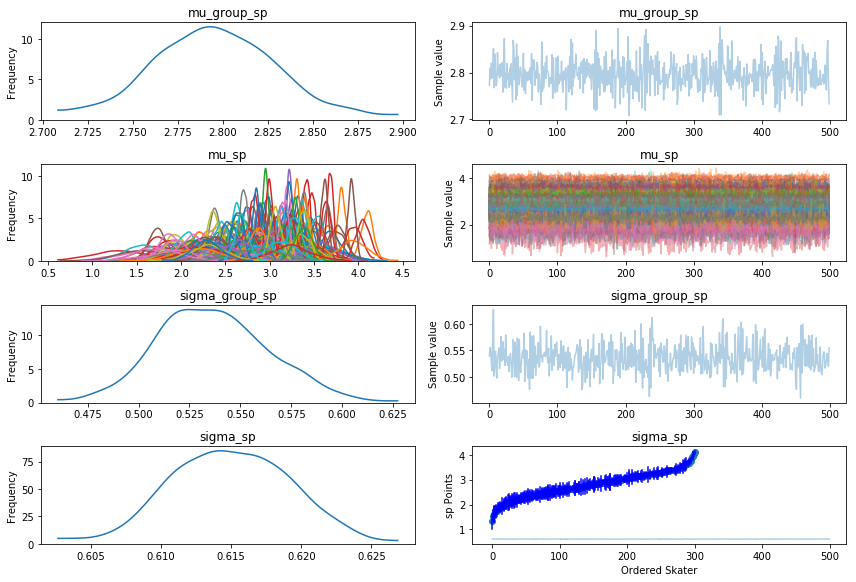

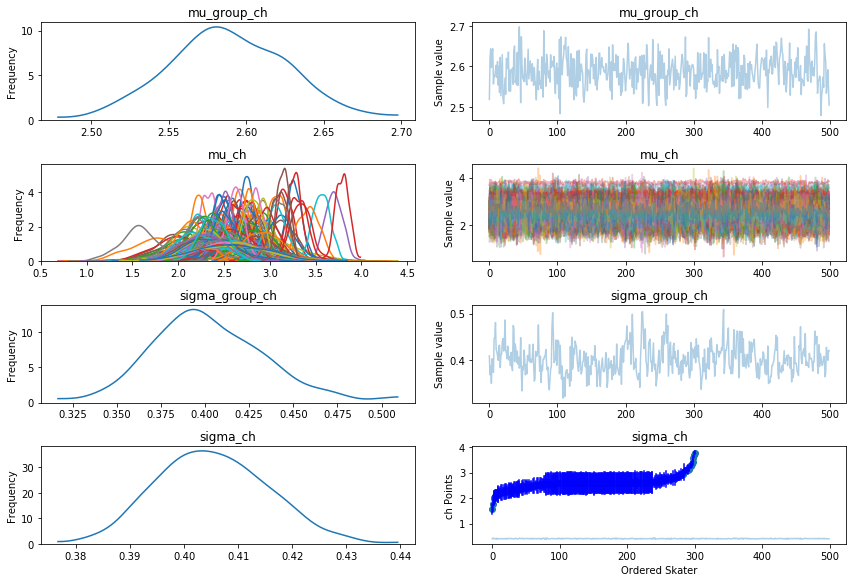

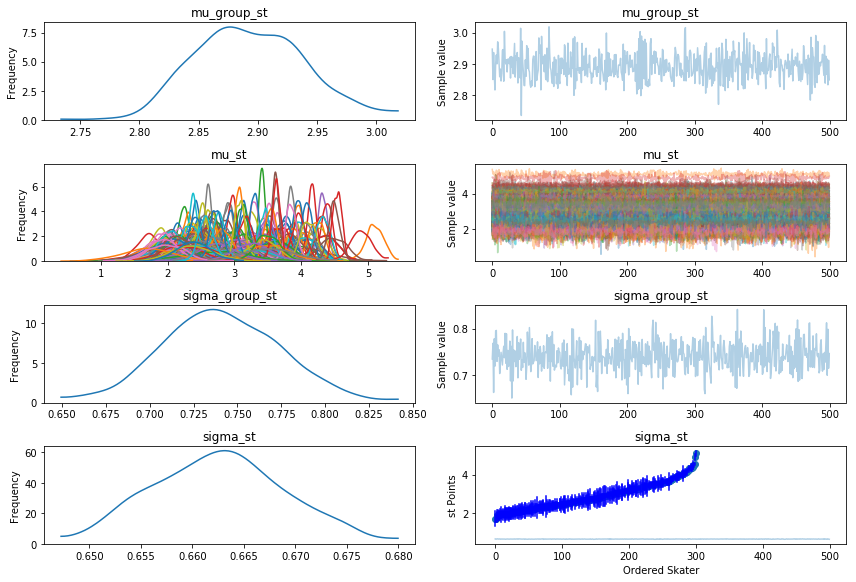

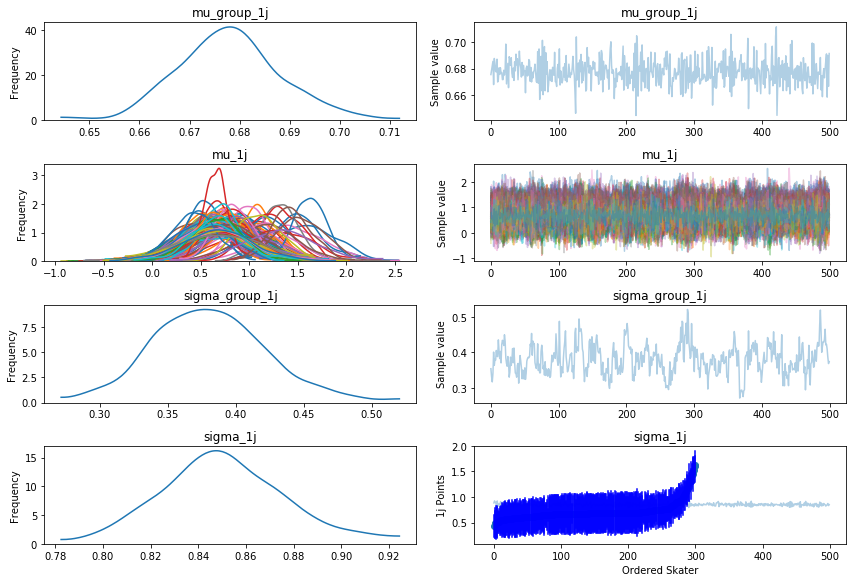

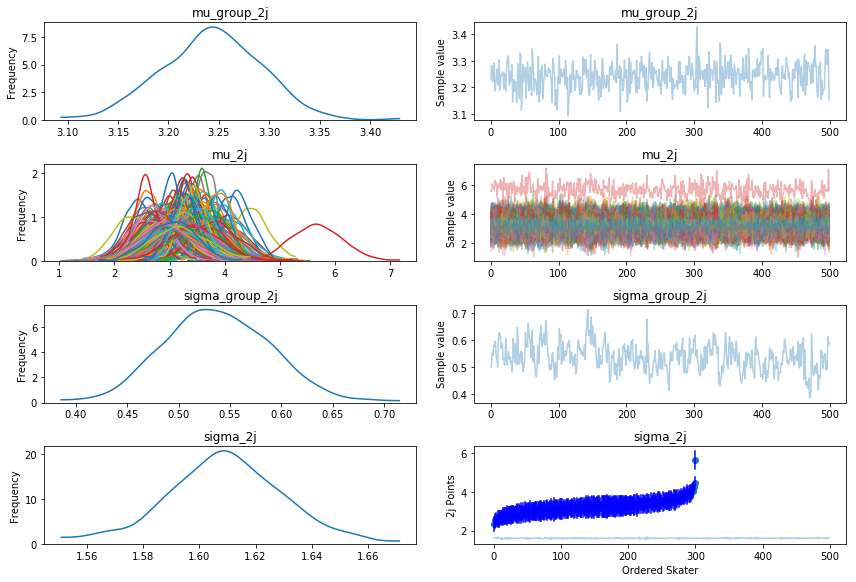

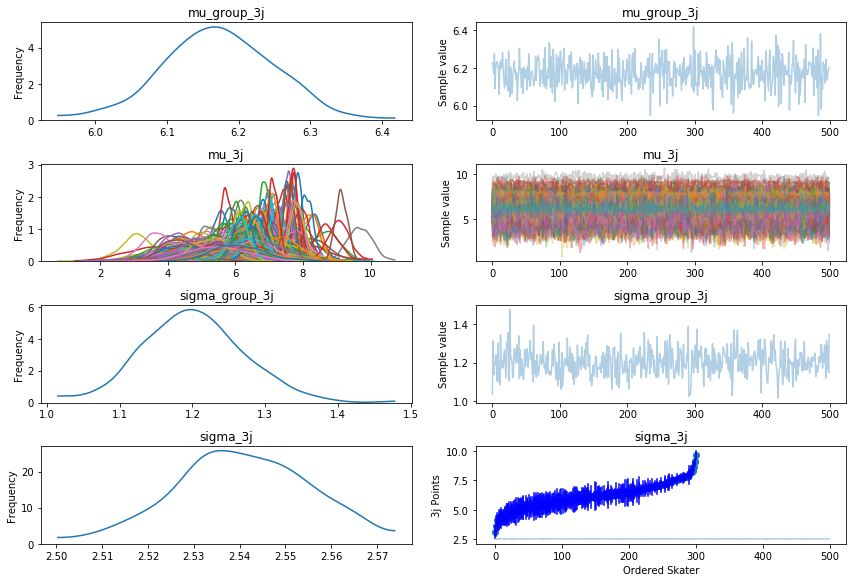

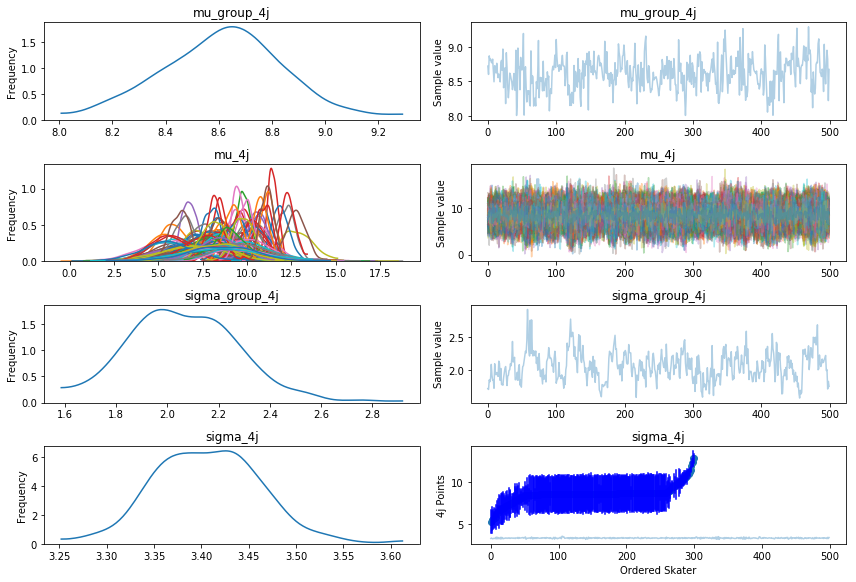

In [8]:
for elt_type, prior_mu, prior_sd in ( ('sp', 2.5, 0.5), ('ch', 2., 0.5), ('st', 3., 0.5), 
                                     ('1j', 0.67, 0.01), ('2j', 4., 0.5), ('3j', 6., 0.7), ('4j', 10.5, 1.0)):
    elts = elements[elements.elt_type == elt_type]
    skater = elts['skater_code'] = elts.skater.replace(skater_lookup).values
    skater = theano.shared(skater)
    points = elts.points
    
    model = pm.Model()
    with model:
        # Prior on group distribution.
        mu_g = pm.Normal('mu_group_' + elt_type, prior_mu, sd=prior_sd)
        sigma_g = pm.HalfCauchy('sigma_group_' + elt_type, 5)
        
        # Group distribution.
        mu = pm.Normal('mu_' + elt_type, mu=mu_g, sd=sigma_g, shape=num_skaters)
        sigma = pm.HalfCauchy('sigma_' + elt_type, 5)  # not used in 1j
        
        # Data model.
        y = pm.Normal('y_' + elt_type, mu[skater], sd=sigma, observed=points)

    # Fit the model.
    with model:
        trace = pm.sample()
        
    # Save the results.
    results[elt_type] = (trace, model, skater)
    
    # Visualize fit.
    pm.traceplot(trace)
    estimates = pd.Series(trace['mu_' + elt_type].mean(axis=0), index=skaters)
    se = pd.Series(trace['mu_' + elt_type].std(axis=0), index=skaters)
    order = estimates.sort_values().index
    plt.scatter(xrange(len(estimates)), estimates[order])
    for i, m, s in zip(range(len(estimates)), estimates[order], se[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(elt_type + ' Points');plt.xlabel('Ordered Skater');

In [9]:
# for comp_type in COMP_TYPES:
#     comps = components[components.comp_type == comp_type]
#     skater = comps['skater_code'] = comps.skater.replace(skater_lookup).values
#     skater = theano.shared(skater)
#     points = comps.points
    
#     model = pm.Model()
#     with model:
#         # Prior on group distribution.
#         mu_g = pm.Beta('mu_group_' + comp_type, alpha=20, beta=7)
#         sigma_g = pm.HalfCauchy('sigma_group_' + comp_type, 5)
        
#         # Group distribution.
#         mu = pm.Normal('mu_' + comp_type, mu=mu_g*10, sd=sigma_g, shape=num_skaters)
#         sigma = pm.HalfCauchy('sigma_' + comp_type, 5)
        
#         # Data model.
#         y = pm.Normal('y_' + comp_type, mu[skater], sd=sigma, observed=points)

#     # Fit the model.
#     with model:
#         trace = pm.sample()
        
#     # Save the results.
#     results[comp_type] = (trace, model, skater)
    
#     # Visualize fit.
#     pm.traceplot(trace)
#     estimates = pd.Series(trace['mu_' + comp_type].mean(axis=0), index=skaters)
#     se = pd.Series(trace['mu_' + comp_type].std(axis=0), index=skaters)
#     order = estimates.sort_values().index
#     plt.scatter(xrange(len(estimates)), estimates[order])
#     for i, m, s in zip(range(len(estimates)), estimates[order], se[order]):
#         plt.plot([i,i], [m-s, m+s], 'b-')
#     plt.ylabel(comp_type + ' Points');plt.xlabel('Ordered Skater');

In [13]:
elements18 = pd.read_csv('pd_data/elements18_men.csv')
components18 = pd.read_csv('pd_data/components_summary18_men.csv')

In [14]:
comps_history = {}   # comps_history[skater][comp_type] is max historical components score for skater

In [16]:
for skater in components18.skater.unique():
    skater_comps = components[components.skater == skater]
    comps_history[skater] = {}
    for comp_type in COMP_TYPES:
        comps_history[skater][comp_type] = skater_comps[skater_comps.comp_type == comp_type].points.max()

In [19]:
all_pbs = {comp_type: [] for comp_type in COMP_TYPES}
for pb in comps_history.values():
    if pd.isnull(pb['co']):
        continue
    for comp_type in COMP_TYPES:
        all_pbs[comp_type].append(pb[comp_type])

In [21]:
comp_avg = {comp_type: np.median(all_pbs[comp_type]) for comp_type in COMP_TYPES}

In [23]:
for skater, pb in comps_history.iteritems():
    if pd.isnull(pb['co']):
        comps_history[skater] = comp_avg

In [24]:
new_skater = len(skater_lookup)

In [25]:
elements18['skater_code'] = elements18.apply(lambda row: skater_lookup.get(row.skater, -1), axis=1)
components18['skater_code'] = components18.apply(lambda row: skater_lookup.get(row.skater, -1), axis=1)

In [26]:
ppc = {}
means = {}

100%|██████████| 500/500 [00:00<00:00, 1041.66it/s]


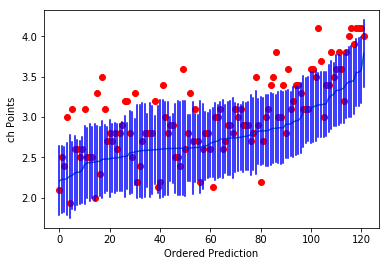

100%|██████████| 500/500 [00:00<00:00, 1714.68it/s]


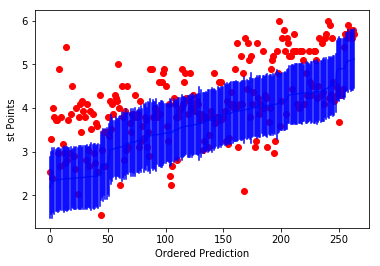

100%|██████████| 500/500 [00:00<00:00, 1003.58it/s]


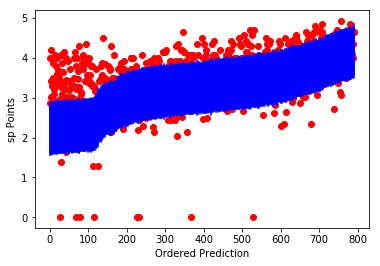

100%|██████████| 500/500 [00:00<00:00, 1864.14it/s]


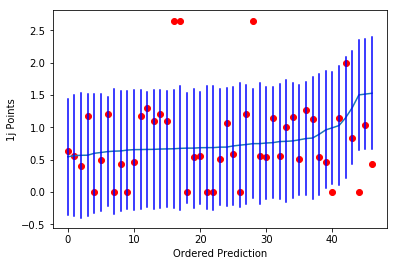

100%|██████████| 500/500 [00:00<00:00, 837.02it/s]


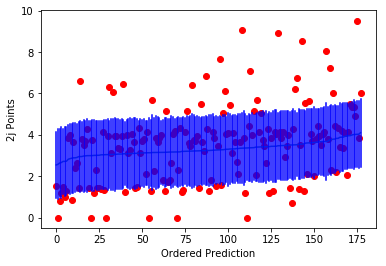

100%|██████████| 500/500 [00:00<00:00, 1157.97it/s]


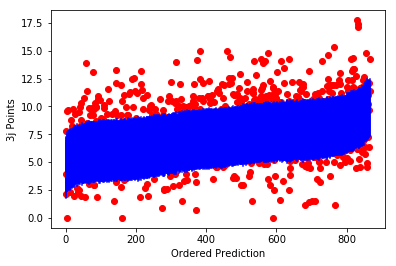

100%|██████████| 500/500 [00:00<00:00, 1505.83it/s]


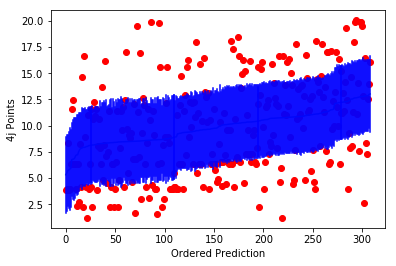

In [27]:
for elt_type in ELT_TYPES:
    with results[elt_type][1]:
        results[elt_type][2].set_value(np.asarray(elements18[elements18.elt_type == elt_type].skater_code))
        ppc[elt_type] = pm.sample_ppc(results[elt_type][0], model=results[elt_type][1], samples=500)['y_' + elt_type]

    mean = means[elt_type] = ppc[elt_type].mean(axis=0)
    std = np.std(ppc[elt_type], axis=0)
    real_outcomes = elements18[elements18.elt_type == elt_type]
    order = pd.Series(mean).sort_values().index
    outcomes = []
    for index in order:
        outcomes.append(real_outcomes.iloc[index].points)
    plt.scatter(xrange(len(mean)), outcomes, color='r')
    plt.plot(xrange(len(mean)), [mean[x] for x in order])
    for i, m, s in zip(xrange(len(mean)), mean[order], std[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(elt_type + ' Points');plt.xlabel('Ordered Prediction');
    plt.show()

100%|██████████| 500/500 [00:00<00:00, 2008.50it/s]


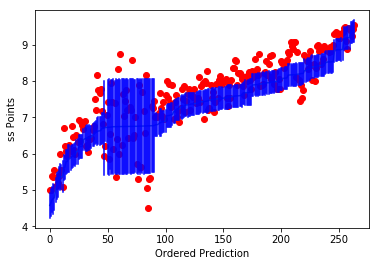

100%|██████████| 500/500 [00:00<00:00, 1430.43it/s]


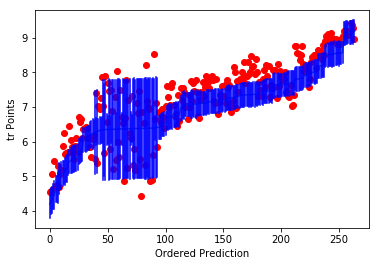

100%|██████████| 500/500 [00:00<00:00, 1911.87it/s]


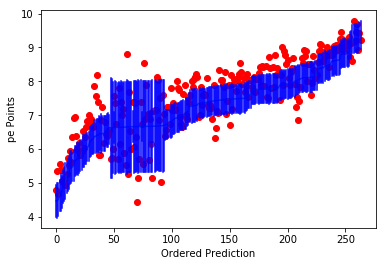

100%|██████████| 500/500 [00:00<00:00, 1855.33it/s]


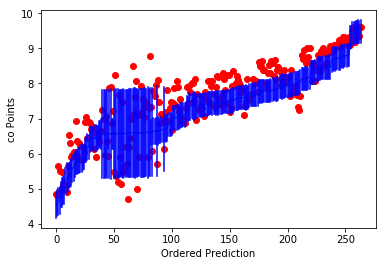

100%|██████████| 500/500 [00:00<00:00, 1936.96it/s]


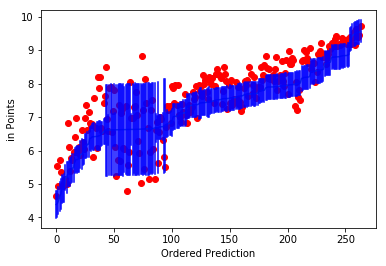

In [138]:
# for comp_type in COMP_TYPES:
#     with results[comp_type][1]:
#         results[comp_type][2].set_value(np.asarray(components18[components18.comp_type == comp_type].skater_code))
#         ppc[comp_type] = pm.sample_ppc(results[comp_type][0], model=results[comp_type][1], samples=500)['y_' + comp_type]
    
#     mean = means[comp_type] = ppc[comp_type].mean(axis=0)
#     std = np.std(ppc[comp_type], axis=0)
    
#     # Sort actual point outcomes by order predicted by model.
#     real_outcomes = components18[components18.comp_type == comp_type]
#     order = pd.Series(mean).sort_values().index
#     outcomes = []
#     for index in order:
#         outcomes.append(real_outcomes.iloc[index].points)
#     plt.scatter(xrange(len(mean)), outcomes, color='r')
#     plt.plot(xrange(len(mean)), [mean[x] for x in order])
#     for i, m, s in zip(xrange(len(mean)), mean[order], std[order]):
#         plt.plot([i,i], [m-s, m+s], 'b-')
#     plt.ylabel(comp_type + ' Points');plt.xlabel('Ordered Prediction');
#     plt.show()

In [28]:
elt_predictions = elements18[['segment', 'event', 'element', 'elt_type', 'points', 'skater', 'skater_code']].copy()
comp_predictions = components18[['comp_type', 'event', 'segment', 'points', 'skater', 'skater_code']].copy()

In [31]:
elt_pred_col = []
elt_indices = {elt_type: 0 for elt_type in ELT_TYPES}
for index, row in elt_predictions.iterrows():
    elt_pred_col.append(means[row.elt_type][elt_indices[row.elt_type]])
    elt_indices[row.elt_type] += 1

In [30]:
comp_pred_col = []
# comp_indices = {comp_type: 0 for comp_type in COMP_TYPES}
for index, row in comp_predictions.iterrows():
    comp_pred_col.append(comps_history[row.skater][row.comp_type])
#     comp_pred_col.append(means[row.comp_type][comp_indices[row.comp_type]])
#     comp_indices[row.comp_type] += 1

In [32]:
elt_predictions['prediction'] = elt_pred_col
comp_predictions['prediction'] = comp_pred_col
comp_predictions.rename(columns={'comp_type': 'elt_type'}, inplace=True)
elt_predictions['is_elt'] = pd.Series([1] * len(elt_pred_col))
comp_predictions['is_elt'] = pd.Series([0] * len(comp_pred_col))

In [33]:
predictions = pd.concat([elt_predictions, comp_predictions])

In [37]:
predictions.to_csv('fits/men_predictions2.5.csv')

In [36]:
predictions[predictions.skater == 'Dmitri ALIEV']

,element,elt_type,event,is_elt,points,prediction,segment,skater,skater_code
14,3Lz+3T,3j,gprus2017,1,11.10,6.131630,gprus2017 men_short,Dmitri ALIEV,-1
15,4T,4j,gprus2017,1,11.73,8.463647,gprus2017 men_short,Dmitri ALIEV,-1
16,CSSp4,sp,gprus2017,1,3.86,2.302143,gprus2017 men_short,Dmitri ALIEV,-1
17,3A,3j,gprus2017,1,9.92,5.942133,gprus2017 men_short,Dmitri ALIEV,-1
18,FCSp3,sp,gprus2017,1,3.01,2.231201,gprus2017 men_short,Dmitri ALIEV,-1
19,StSq4,st,gprus2017,1,4.90,2.356502,gprus2017 men_short,Dmitri ALIEV,-1
20,CCoSp4,sp,gprus2017,1,3.93,2.306773,gprus2017 men_short,Dmitri ALIEV,-1
162,4Lz<,4j,gprus2017,1,8.13,8.675783,gprus2017 men_free,Dmitri ALIEV,-1
163,3F,3j,gprus2017,1,5.70,6.039118,gprus2017 men_free,Dmitri ALIEV,-1
164,4T+3T,4j,gprus2017,1,15.60,8.664751,gprus2017 men_free,Dmitri ALIEV,-1
